<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/1012_MRC_Mission2_Generation_based_MRC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5를 활용해서 Generation-based MRC 문제를 풀어보기

두번째 미션에서는 **3강에서 배운 Generation based MRC**를 구현합니다!
> Remind !🤔  
* Extraction-based MRC : 지문 내 답의 위치를 예측 (classification) , 주어진 지문 내에 무조건 답이 존재함
* Generation-based MRC : 주어진 지문과 질의를 통해 답변을 생성함(Generation) , 주어진 지문 내에 답이 존재하지 않아도 되며 비교적 유연함

* 주어진 지문과 질의을 기반으로 적절한 답을 생성하는것이 오늘의 목표
* T5 모델을 활용하여 문제를 풀어볼 예정이니, T5에 대한 사전 지식이 필요합니다 
* T5는 encoder-decoder 구조의 모델이니 encoder만으로 구성된 BERT와는 구조가 상이합니다
* 해당 미션은 빈칸이 없습니다. 코드 한줄씩 살펴보면서 의미를 확인해보세요 !


```
🛠 Setup을 하는 부분입니다. 이전 과제에서 반복되는 부분이기 때문에 무지성 실행 하셔도 좋습니다.
💻 실습 코드입니다. 따라가면서 코드를 이해해보세요.
```

## 🛠 초기설정

### 🛠 Requirements

In [1]:
# Output model file을 저장하기위해 drive 마운트를 수행합니다
# 마운트를 진행하지 않은 경우, 모델의 크기가 커질 경우엔 디스크 용량이 부족하여 에러가 발생할 수 있습니다
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Requirements
!pip install tqdm==4.48.0 -q
!pip install datasets==1.4.1 -q
!pip install transformers==4.5.0 -q
!pip install sentencepiece==0.1.95 -q
!pip install nltk -q

     |████████████████████████████████| 67 kB 2.7 MB/s 
     |████████████████████████████████| 186 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 31.6 MB/s 
     |████████████████████████████████| 125 kB 52.0 MB/s 
     |████████████████████████████████| 2.1 MB 2.0 MB/s 
     |████████████████████████████████| 3.3 MB 20.7 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [3]:
import nltk
# nltk는 postprocess를 위해 import합니다 - postprocess_text 함수 참고
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 🛠 난수 고정 및 버전 확인

In [4]:
import random
import numpy as np
import torch

# pytorch version, device 정보 확인하기 
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu111].
device:[cuda:0].


In [5]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42) # magic number :)

### 🛠 데이터 및 평가 지표 불러오기

In [6]:
from datasets import load_dataset

datasets = load_dataset("squad_kor_v1")

Dataset squad_kor_v1 downloaded and prepared to /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/31982418accc53b059af090befa81e68880acc667ca5405d30ce6fa7910950a7. Subsequent calls will reuse this data.


In [7]:
from datasets import load_metric

metric = load_metric("squad")

##  💻 T5를 활용하여 Generation based QA 모델 구현하기

### 💻 Pre-trained 모델 및 토크나이저 불러오기

In [8]:
"""
[간단 설명]

1. huggingface의 transformers 라이브러리를 통해 모델을 불러옵니다
2. AutoModel을 사용하면 원하는 모델을 이름만 바꾸어 불러 올 수 있습니다
3. QuestionAnswering을 위한 모델이 이미 구축되어있기 때문에 편하게 불러와서 사용 할 수 있습니다
4. 대용량 데이터로 기학습된 모델을 불러와서 사용합니다 (기학습된 == Pretrained)
"""
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer
)

In [9]:
model_name = "google/mt5-small"

In [ ]:
# T5는 seq2seq 모델이므로 model을 불러올 때 AutoModelForSeq2SeqLM을 사용해야 함
config = AutoConfig.from_pretrained(
    model_name,
    cache_dir=None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    config=config,
    cache_dir=None,
)

In [ ]:
# model 구조 살펴보기
model 

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedGeluDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (w

### 💻 파라미터 설정하기

In [ ]:
# 데이터 전처리를 위한 파라미터 
max_source_length = 1024
max_target_length = 128
padding = False

# 학습을 위한 파라미터
preprocessing_num_workers=12
num_beams = 2
max_train_samples = 16
max_val_samples = 16
batch_size = 4
num_train_epochs = 30

### 💻 전처리하기

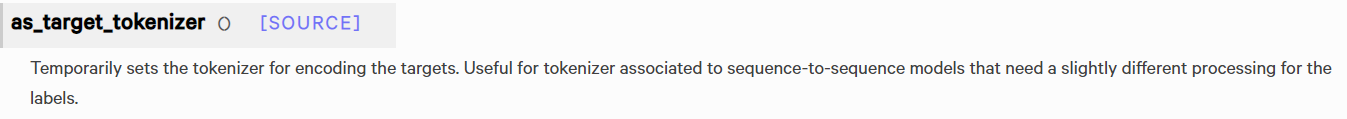

In [ ]:
def preprocess_function(examples):
    inputs = [f"question: {q}  context: {c} </s>" for q, c in zip(examples["question"], examples["context"])]
    targets = [f'{a["text"][0]} </s>' for a in examples['answers']]
    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length,
        padding=padding,
        truncation=True
    )

    # targets(label)을 위해 tokenizer 설정
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            padding=padding,
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    model_inputs["example_id"] = []
    for i in range(len(model_inputs["labels"])):
        model_inputs["example_id"].append(examples["id"][i])
    return model_inputs

In [ ]:
column_names = datasets["train"].column_names

In [ ]:
# 전체 train dataset을 사용하는 예제가 아니고, sampling된 데이터를 사용하는 코드입니다. 적절하게 코드를 수정하여 사용하셔도 좋습니다.

train_dataset = datasets["train"]
train_dataset = train_dataset.select(range(max_train_samples))
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)

In [ ]:
# 전체 데이터로 평가
eval_examples = datasets["validation"]

# 샘플 데이터로 평가
# eval_examples = eval_examples.select(range(max_val_samples)) 

eval_dataset = eval_examples.map(
    preprocess_function,
    batched=True,
    num_proc=preprocessing_num_workers,
    remove_columns=column_names,
    load_from_cache_file=False,
)


### 💻 Fine-tuning하기

In [ ]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

In [ ]:
label_pad_token_id = tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=None,
)

In [ ]:
def postprocess_text(preds, labels):
  """
  postprocess는 nltk를 이용합니다.
  Huggingface의 TemplateProcessing을 사용하여
  정규표현식 기반으로 postprocess를 진행할 수 있지만
  해당 미션에서는 nltk를 이용하여 간단한 후처리를 진행합니다
  """

  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]
    
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

def compute_metrics(eval_preds):
  preds, labels = eval_preds
  if isinstance(preds, tuple):
      preds = preds[0]
  
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  # decoded_labels은 rouge metric을 위한 것이며, f1/em을 구할 때 사용되지 않음
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # 간단한 post-processing
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  formatted_predictions = [{"id": ex["id"], "prediction_text": decoded_preds[i]} for i, ex in enumerate(datasets["validation"].select(range(max_val_samples)))]
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"].select(range(max_val_samples))]

  result = metric.compute(predictions=formatted_predictions, references=references)
  return result

In [ ]:
args = Seq2SeqTrainingArguments(
    output_dir='outputs', 
    do_train=True, 
    do_eval=True, 
    predict_with_generate=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    save_strategy='epoch',
    save_total_limit=2 # 모델 checkpoint를 최대 몇개 저장할지 설정
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
train_result = trainer.train(resume_from_checkpoint=None)

Step,Training Loss


In [ ]:
train_result

TrainOutput(global_step=120, training_loss=32.5375732421875, metrics={'train_runtime': 1777.315, 'train_samples_per_second': 0.068, 'total_flos': 429387257432064.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 927588352, 'init_mem_gpu_alloc_delta': 1200707584, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -329199616, 'train_mem_gpu_alloc_delta': 3625318400, 'train_mem_cpu_peaked_delta': 371867648, 'train_mem_gpu_peaked_delta': 2061845504})

### 💻 평가하기

In [ ]:
metrics = trainer.evaluate(
    max_length=max_target_length,
    num_beams=num_beams,
    metric_key_prefix="eval"
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [ ]:
metrics

{'epoch': 30.0,
 'eval_exact_match': 0.0,
 'eval_f1': 1.5625,
 'eval_loss': 23.192293167114258,
 'eval_mem_cpu_alloc_delta': 60768256,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 529559552,
 'eval_runtime': 2410.8254,
 'eval_samples_per_second': 2.395}

In [ ]:
document = "세종대왕님은 언제 태어났어?"
input_ids = tokenizer(document, return_tensors='pt').input_ids
outputs = model.generate(input_ids.to('cuda'))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'<extra_id_0>?'

In [ ]:
outputs

tensor([[     0, 250099,    291,      1]], device='cuda:0')